# ECM-MPT Data Analysis

Extracellular-Matrix Multiple Particle Tracking data analysis and prediciton of pup age in P14, P21, P28, and P35 datasets. 


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.---Load-Data" data-toc-modified-id="1.---Load-Data-1">1.   Load Data</a></span></li><li><span><a href="#2.---Analysis" data-toc-modified-id="2.---Analysis-2">2.   Analysis</a></span></li><li><span><a href="#3.---Modelling" data-toc-modified-id="3.---Modelling-3">3.   Modelling</a></span></li><li><span><a href="#4.---Evaluate-Results" data-toc-modified-id="4.---Evaluate-Results-4">4.   Evaluate Results</a></span></li></ul></div>

---

## 1.   Load Data

Loading feature dataset from AWS NanceLab Bucket: p14, p21, p28, data are present on mckenna.data/08_06_19_MPT_age_dependence while p35 data is present on mckenna.data/07_16_19_MPT_ECM_breakdown. This bucket is only available through access with Nance lab.

There are 15 total videos from each age group. Names of each dataset downloaded are present on dwnld_list.txt.

In [186]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import xgboost as xgb
from xgboost import cv

import shap

In [5]:
# pd.read ...

dwnld_list = []
source_bucket = 'dash2927.data'
source_folder = 'ECM_work'
keyword = ['40nm', 'NT_brain_2']
s3 = boto3.resource('s3')
bucket = s3.Bucket(source_bucket)

for object in bucket.objects.all():
    folder, filename = ('/'.join(object.key.split("/")
                                 [:-1]), object.key.split("/")[-1])
    # only look in remote_folder and if any keyword(s) math filename
    if folder in source_folder and any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)):
        dwnld_list.append(s3.Object(object.bucket_name, object.key))

dwnld_list = [filename.key for filename in dwnld_list if 'features' in filename.key]

In [6]:
dwnld_list

['ECM_work/features_NT_brain_2_slice_1_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_5.csv',
 'ECM_work/features_P14_40nm_s1_v1.csv',
 'ECM_work/features_P14_40nm_s1_v2.csv',
 'ECM_work/features_P14_40nm_s1_v3.csv',
 'ECM_work/features_P14_40nm_s1_v4.csv',
 'ECM_work/features_P14_40nm_s1_v5.csv',
 'ECM_work/features_P14_40nm_s2_v1.csv',
 'ECM_work/features_P14_40nm_s2_v2.csv',
 'ECM_work/features_P14_40nm_s2_v3.csv',
 'ECM_work/features_P14_40nm_s2_v4.csv',
 'ECM_work/features_P14_40nm_s2_v5.csv',
 'ECM_work/features_P14_40nm_s3_v1.csv',
 'ECM_work/features_P14_40nm_s3_v2.csv',
 'ECM_work/features_P14_40nm_s3_v3.csv',
 'ECM_work/features_P14_40nm_s3_v4.csv',
 'ECM_work/features_P14_40nm_s3_v5.csv',
 'ECM_work/features_P21_40nm_s1_v1.csv',
 'ECM_work/features_P21_40nm_s1_v2.csv',
 'ECM_work/features_P21_40nm_s1_v3.csv',
 'ECM_work/features_P21_40nm_s1_v4.csv',
 'ECM_work/features_P21_40nm_s1_v5.csv',
 'ECM_work/features_P21_40nm_s2_v1.csv',
 'ECM_work/features_P21_40nm_s2_v2.csv',
 'ECM_work/features_P21_40nm_s2_v3.csv',
 'ECM_work/features_P21_40nm_s2_v4.csv',
 'ECM_work/features_P21_40nm_s2_v5.csv',
 'ECM_work/features_P21_40nm_s3_v1.csv',
 'ECM_work/features_P21_40nm_s3_v2.csv',
 'ECM_work/features_P21_40nm_s3_v3.csv',
 'ECM_work/features_P21_40nm_s3_v4.csv',
 'ECM_work/features_P21_40nm_s3_v5.csv',
 'ECM_work/features_P28_40nm_s1_v1.csv',
 'ECM_work/features_P28_40nm_s1_v2.csv',
 'ECM_work/features_P28_40nm_s1_v3.csv',
 'ECM_work/features_P28_40nm_s1_v4.csv',
 'ECM_work/features_P28_40nm_s1_v5.csv',
 'ECM_work/features_P28_40nm_s2_v1.csv',
 'ECM_work/features_P28_40nm_s2_v2.csv',
 'ECM_work/features_P28_40nm_s2_v3.csv',
 'ECM_work/features_P28_40nm_s2_v4.csv',
 'ECM_work/features_P28_40nm_s2_v5.csv',
 'ECM_work/features_P28_40nm_s3_v1.csv',
 'ECM_work/features_P28_40nm_s3_v2.csv',
 'ECM_work/features_P28_40nm_s3_v3.csv',
 'ECM_work/features_P28_40nm_s3_v4.csv',
 'ECM_work/features_P28_40nm_s3_v5.csv']

In [14]:
cnt = 0
for dwnld_file in dwnld_list:
    folder, filename = (dwnld_file.split("/")[0], dwnld_file.split("/")[-1])
    try:
        aws.download_s3(dwnld_file, filename, bucket_name=source_bucket)
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[cnt], index=fstats.index)
        cnt += 1
        if cnt == 1:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    except:
            print('Skipped!: {}'.format(filename))
    

features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P14_40nm_s1_v4.csv size: (140, 91)
featur

In [16]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

## 2.   Analysis

In [17]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

In [84]:
fstats_tot
features = [
    'alpha', 
    'D_fit', 
    'kurtosis', 
    'asymmetry1', 
    'asymmetry2',
    'asymmetry3', 
    'AR', 
    'elongation', 
    'boundedness', 
    'fractal_dim',
    'trappedness', 
    'efficiency', 
    'straightness', 
    'MSD_ratio', 
    'frames',   
    'Deff1', 
    'Deff2',
    'angle_mean', 
    'angle_mag_mean', 
    'angle_var', 
    'dist_tot', 
    'dist_net', 
    'progression', 
    'Mean alpha',
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',  
]

target = 'age'           # prediction target (y) (+1 means safe, -1 is risky)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]

In [85]:
ecm.head()

Track_ID     alpha      D_fit  kurtosis  asymmetry1  asymmetry2  \
0       0.0  0.445227  16.493781  5.457711    0.900742    0.161642   
1       1.0  0.107756   0.316246  3.334612    0.071551    0.760212   
2       2.0  0.046968   0.440548  2.587983    0.054303    0.788683   
3       3.0  1.759901   2.452218  2.516403    0.984714    0.062057   
4       4.0  0.438945   8.270880  2.176721    0.997136    0.026778   

   asymmetry3        AR  elongation  boundedness  ...  Mean convex_hull_norm  \
0    0.301680  2.104323    0.524788     0.040769  ...                    0.0   
1    0.009322  1.213024    0.175614     0.096920  ...                    0.0   
2    0.007003  1.087747    0.080668     0.098123  ...                    0.0   
3    0.494242  3.654338    0.726353     0.105210  ...                    0.0   
4    0.596387  5.244316    0.809317     0.227229  ...                    0.0   

   Std convex_hull_norm  Mean dist_tot  Std dist_tot  Mean dist_net  \
0                   0.0   53446.037923  39383.730785    2193.565956   
1                   0.0   69929.668778  50752.744606    1793.547419   
2                   0.0   69929.668778  50752.744606    1793.547419   
3                   0.0   53446.037923  39383.730785    2193.565956   
4                   0.0   53446.037923  39383.730785    2193.565956   

   Std dist_net  Mean progression  Std progression  age  Video Number  
0     17.904650          0.065281         0.040573   35             0  
1      1.447172          0.053308         0.044553   35             0  
2      1.447172          0.053308         0.044553   35             0  
3     17.904650          0.065281         0.040573   35             0  
4     17.904650          0.065281         0.040573   35             0  

[5 rows x 93 columns]

In [86]:
ecm_14 = ecm[ecm[target] == 14]
ecm_21 = ecm[ecm[target] == 21]
ecm_28 = ecm[ecm[target] == 28]
ecm_35 = ecm[ecm[target] == 35]
print(f"Ratio before data balance (P14:P21:P28:P35) = {len(ecm_14)}:{len(ecm_21)}:{len(ecm_28)}:{len(ecm_35)}")
ecm_list = [ecm_14, ecm_21, ecm_28, ecm_35]
for i in range(len(ecm_list)):
    ratio = 6000/len(ecm_list[i])
    ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
print(f"Ratio before after balance (P14:P21:P28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}:{len(ecm_list[3])}")
bal_ecm = pd.concat(ecm_list)

Ratio before data balance (P14:P21:P28:P35) = 6416:20665:6194:17169
Ratio before after balance (P14:P21:P28:P35) = 6000:6000:6000:6000


## 3.   Modelling

In [87]:
# Using checkerboard binning for data split:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [88]:
# cld ...                                 
# Split dataset into training set and test set
# train_data, validation_data = train_test_split(bal_ecm, test_size=0.2, random_state=1)

bins = list(range(0, 2048+1, 256))
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

cols = bal_ecm.columns.tolist()
cols = cols[-3:] + cols[:-3]
bal_ecm = bal_ecm[cols]

In [128]:
le = preprocessing.LabelEncoder()
X_train = bal_ecm[~bel_ecm.bins.isin(checkerboard(8))].reset_index()
X_test_val =  bel_ecm[bel_ecm.bins.isin(checkerboard(8))].reset_index()
y_train = le.fit_transform(X_train[target])
# y_test = le.fit_transform(X_test_val['Type and Serum'])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test[target])
y_val = le.fit_transform(X_val[target])
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [145]:
param = {'max_depth': 7,
         'eta': 0.2,
         'min_child_weight': 1,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 0,
         'subsample': 0.8,
         'colsample_bytree': 0.9}

In [151]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-merror:0.545424	train-merror:0.273142
[1]	eval-merror:0.503688	train-merror:0.227314
[2]	eval-merror:0.481562	train-merror:0.206762
[3]	eval-merror:0.480389	train-merror:0.181818
[4]	eval-merror:0.486591	train-merror:0.156294
[5]	eval-merror:0.48525	train-merror:0.14983
[6]	eval-merror:0.481227	train-merror:0.140631
[7]	eval-merror:0.479048	train-merror:0.133256
[8]	eval-merror:0.466477	train-merror:0.121488
[9]	eval-merror:0.467147	train-merror:0.117428
[10]	eval-merror:0.47469	train-merror:0.110881
[11]	eval-merror:0.476701	train-merror:0.102842
[12]	eval-merror:0.471505	train-merror:0.098948
[13]	eval-merror:0.474187	train-merror:0.091241
[14]	eval-merror:0.476366	train-merror:0.08776
[15]	eval-merror:0.477372	train-merror:0.081379
[16]	eval-merror:0.468991	train-merror:0.072926
[17]	eval-merror:0.469997	train-merror:0.071186
[18]	eval-merror:0.467985	train-merror:0.067042
[19]	eval-merror:0.46832	train-merror:0.064805
[20]	eval-merror:0.468823	train-merror:0.062319
[21]	ev

In [152]:
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.5217026981732864


In [182]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 4.   Evaluate Results

In [157]:
print('0 == {}'.format(le.inverse_transform([0])))
print('1 == {}'.format(le.inverse_transform([1])))
print('2 == {}'.format(le.inverse_transform([2])))
print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']

0 == [14]
1 == [21]
2 == [28]
3 == [35]


In [155]:
print(classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35']))

              precision    recall  f1-score   support

         P14     0.6612    0.7623    0.7082      1485
         P21     0.4380    0.4558    0.4467      1549
         P28     0.3852    0.2457    0.3000      1461
         P35     0.5354    0.6223    0.5756      1472

    accuracy                         0.5217      5967
   macro avg     0.5049    0.5215    0.5076      5967
weighted avg     0.5046    0.5217    0.5076      5967



* Training trajectories for each age
* Weighted score at the bottom
* 

In [156]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[features])

In [125]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1])

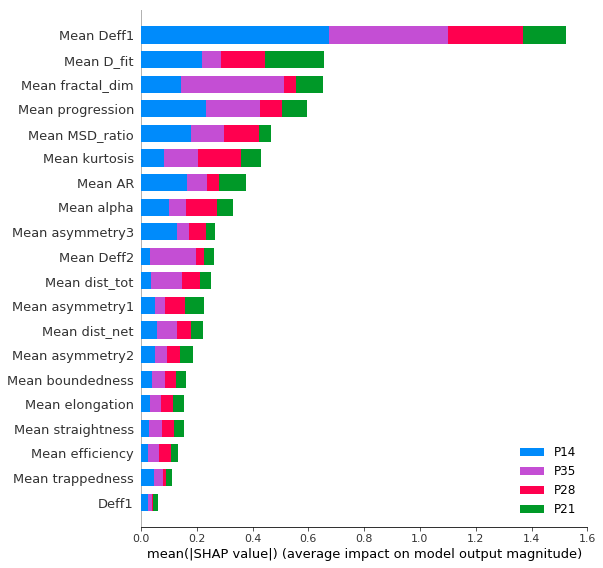

In [163]:
shap.summary_plot(shap_values, X_test[features], class_names = class_names)

In [210]:
%matplotlib inline

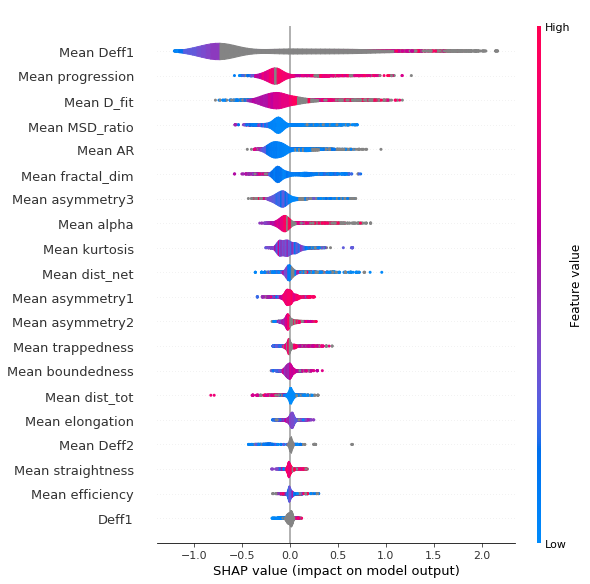

In [211]:
shap.summary_plot(shap_values[0], X_test[features], class_names = class_names, title = 'SHAP Value for P14', plot_type='violin')

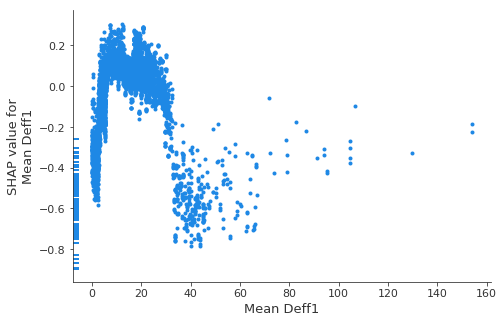

In [213]:
shap.dependence_plot("Mean Deff1", shap_values[1], X_test[features], interaction_index = None)

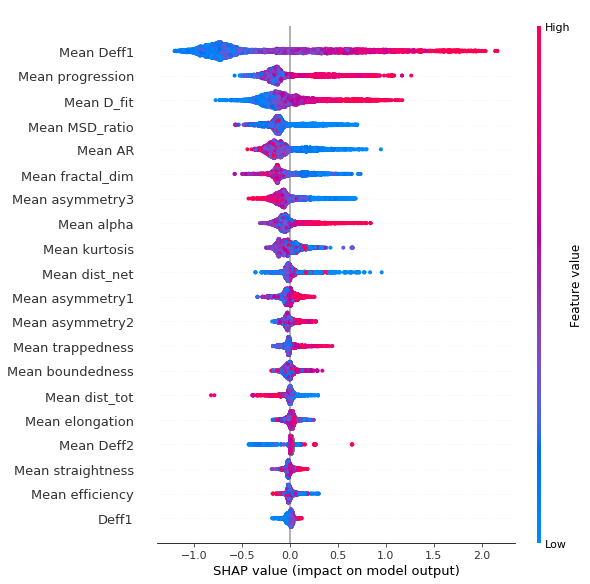

In [214]:
shap.summary_plot(shap_values[0], X_test[features], class_names = class_names, title = 'SHAP Value for P21')

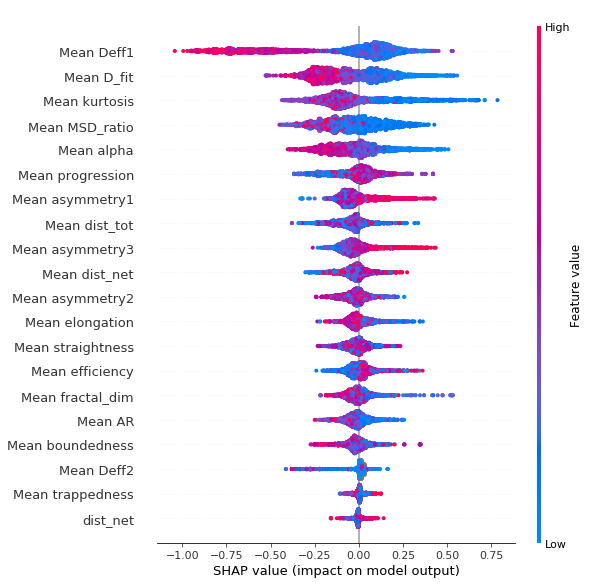

In [173]:
shap.summary_plot(shap_values[2], X_test[features], class_names = class_names, title='SHAP Value for P28')

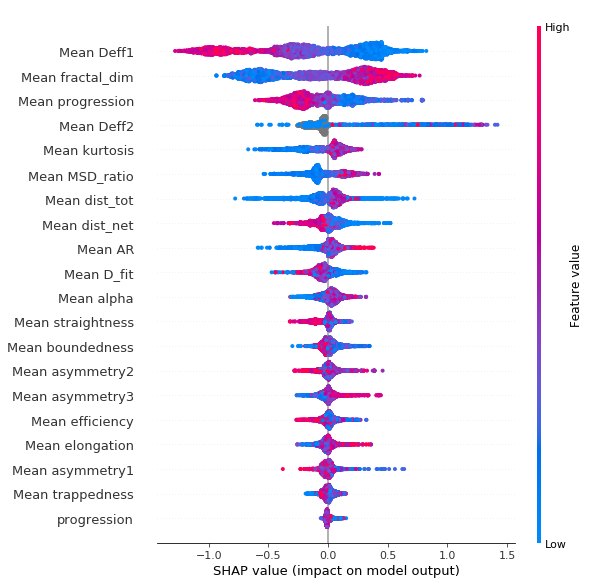

In [174]:
shap.summary_plot(shap_values[3], X_test[features], class_names = class_names, title = 'SHAP Value for P35')

In [180]:
y_test

array([2, 1, 0, ..., 1, 0, 1])

In [184]:
top_feat = ['Mean Deff1', 'Mean D_fit', 'Mean fractal_dim', 'Mean progression', 'Mean kurtosis']

<IPython.core.display.Javascript object>


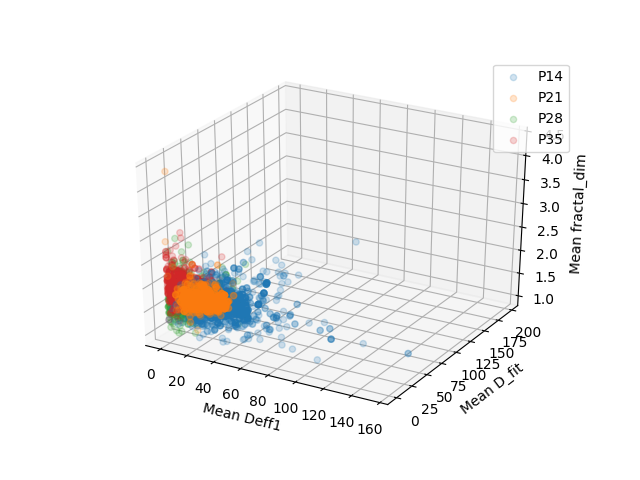

In [217]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d

fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
df_P14_pred = results[results['predicted'] == 0]
df_P21_pred = results[results['predicted'] == 1]
df_P28_pred = results[results['predicted'] == 2]
df_P35_pred = results[results['predicted'] == 3]


ax.scatter(df_P14_pred[top_feat[0]], df_P14_pred[top_feat[1]], df_P14_pred[top_feat[2]], marker = 'o', alpha = 0.2)
ax.scatter(df_P21_pred[top_feat[0]], df_P21_pred[top_feat[1]], df_P21_pred[top_feat[2]], marker = 'o', alpha = 0.2)
ax.scatter(df_P28_pred[top_feat[0]], df_P28_pred[top_feat[1]], df_P28_pred[top_feat[2]], marker = 'o', alpha = 0.2)
ax.scatter(df_P35_pred[top_feat[0]], df_P35_pred[top_feat[1]], df_P35_pred[top_feat[2]], marker = 'o', alpha = 0.2)

ax.set_xlabel(top_feat[0])
ax.set_ylabel(top_feat[1])
ax.set_zlabel(top_feat[2])
leg = pl.legend(['P14', 'P21', 'P28', 'P35'])

<IPython.core.display.Javascript object>


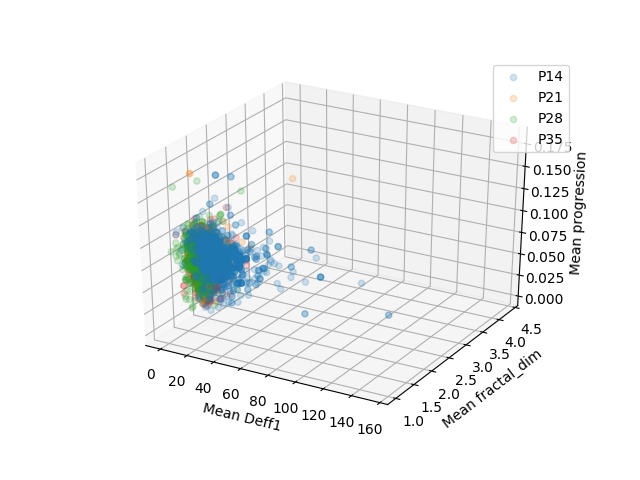

In [216]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d

fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
df_P14_pred = results[results['predicted'] == 0]
df_P21_pred = results[results['predicted'] == 1]
df_P28_pred = results[results['predicted'] == 2]
df_P35_pred = results[results['predicted'] == 3]


ax.scatter(df_P14_pred[top_feat[0]], df_P14_pred[top_feat[2]], df_P14_pred[top_feat[3]], marker = 'o', alpha = 0.2)
ax.scatter(df_P21_pred[top_feat[0]], df_P21_pred[top_feat[2]], df_P21_pred[top_feat[3]], marker = 'o', alpha = 0.2)
ax.scatter(df_P28_pred[top_feat[0]], df_P28_pred[top_feat[2]], df_P28_pred[top_feat[3]], marker = 'o', alpha = 0.2)
ax.scatter(df_P35_pred[top_feat[0]], df_P35_pred[top_feat[2]], df_P35_pred[top_feat[3]], marker = 'o', alpha = 0.2)

ax.set_xlabel(top_feat[0])
ax.set_ylabel(top_feat[2])
ax.set_zlabel(top_feat[3])
leg = pl.legend(['P14', 'P21', 'P28', 'P35'])

* Try analysis without P21 data
* Try combining
* Do a video of 3d plots
* SHAP summitive
* SHAP bounds
* Keep wrking on random forest


* While waiting for review
* Pot. change algorithm to rand forest


* On exp end, Mike will get adult dataset


* Make methods: how data was split, how training eval test, SHAP, algorithm, link to github
* Wrk on discusion (why, limitations, etc)
* Results

* Nxt chkpt: January 17th 